In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import copy
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

In [2]:
###### hyper_Parameters ######
data_set_num = 9
start_from_index = 100
plt.figure(figsize=(10,6))
test_split = 0.1
past_window = 30
future_prediction = 1

<Figure size 720x432 with 0 Axes>

In [3]:
# reading the data into data frames using pandas
"""
data_csv is a list of 10 data frames holding a [2,] list for each symboL
the first one (for example data_csv[i][0] ) is the name of the symbol and
the second one (for example data_csv[i][1] ) is the data assosiated to it
"""
data_csv = []
i = 0
for filename in glob.glob('data/*.csv'):
    data_csv.append([filename[5:len(filename)-4],pd.read_csv(filename).drop("<TICKER>",1)])
    i+=1
# print(data_csv[0][0])
# data_csv[0][1].head()

5 features of : tapico


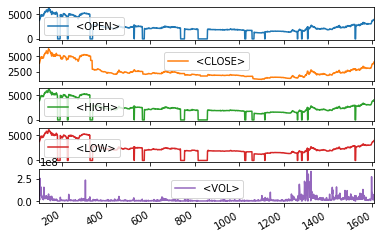

In [4]:
features = data_csv[data_set_num][1][['<OPEN>', '<CLOSE>', '<HIGH>', '<LOW>', '<VOL>']]
features = features[start_from_index:len(features)]
print(f"5 features of : {data_csv[data_set_num][0]}")
features.plot(subplots=True)
plt.show()

     <CLOSE> for : tapico


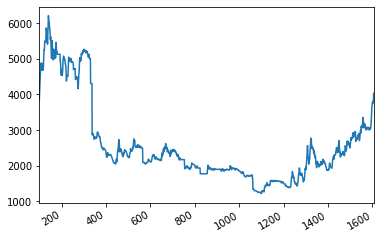

In [5]:
print(f"     <CLOSE> for : {data_csv[data_set_num][0]}")
features["<CLOSE>"].plot(subplots=True)
plt.show()

In [6]:
def trun_to_windows(input,kernel,future):
    data = []
    labels = []
    for i in range(kernel,len(input)-future):
        data.append(input[i-kernel:i])
        labels.append(input[i:i+future,1])
    return np.array(data),np.array(labels).reshape(len(labels),future)

def smooth(input):
    output = []
    output.append(input[0])
    output.append(np.mean([input[0],input[1]]))
    for i in range(2,len(input)-2):
        mean = np.mean([input[i-2],input[i-1],input[i],input[i+1],input[i+2]])
        output.append(mean)
    output.append(np.mean([input[len(input)-2],input[len(input)-1]]))
    output.append(input[len(input)-1])
    return output

In [7]:
data,labels = trun_to_windows(features.values,past_window,future_prediction)
org_data = data
org_labels = labels
# normalize the dataset
data_std = np.std(data, axis=0)
data_mean = np.mean(data, axis=0)
labels_std = np.std(labels, axis=0)
labels_mean = np.mean(labels, axis=0)
# normalize
data = (data - data_mean) / data_std
labels = (labels - labels_mean) / labels_std
print(f"data shape: {data.shape} , labels shape: {labels.shape}")

data shape: (1478, 30, 5) , labels shape: (1478, 1)


In [8]:
################################################
# from the Models belwo , only one should be run
# the first one , dense only
# the seconds one , 1 lstm + 1 Dense
# the third one , 2 lstm + 1 Dense   ---->  should be run
#################################################

In [9]:
# model = keras.Sequential()
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(20))
# model.compile(optimizer='adam', loss='mae')
# hist = model.fit(data,labels,epochs=50)
# loss = model.evaluate(data,labels,verbose=3)
# print("loss = "+str(loss))

In [10]:
# model = keras.Sequential()
# model.add(keras.layers.LSTM(60, activation='relu', input_shape=data[0].shape))
# model.add(keras.layers.Dense(labels.shape[1]))
# model.compile(optimizer='adam', loss='mae')
# hist = model.fit(data,labels,epochs=25,batch_size=32)
# loss = model.evaluate(data,labels,verbose=3)
# print("loss = "+str(loss))

In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(80, activation='relu',return_sequences = True, input_shape=data[0].shape))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(20, activation='relu'))
model.add(keras.layers.Dense(future_prediction))
model.compile(optimizer='adam', loss='mae')
hist = model.fit(data,labels,validation_split=0.1,epochs=10,batch_size=32)
loss = model.evaluate(data,labels,verbose=3)
print("loss = "+str(loss))

Train on 1330 samples, validate on 148 samples
Epoch 1/10
1330/1330 [==============================] - 11s 8ms/sample - loss: 0.3054 - val_loss: 0.1954
Epoch 2/10
1330/1330 [==============================] - 4s 3ms/sample - loss: 0.1134 - val_loss: 0.2123
Epoch 3/10
1330/1330 [==============================] - 5s 4ms/sample - loss: 0.0987 - val_loss: 0.1924
Epoch 4/10
1330/1330 [==============================] - 8s 6ms/sample - loss: 0.0926 - val_loss: 0.1417
Epoch 5/10
1330/1330 [==============================] - 7s 5ms/sample - loss: 0.0924 - val_loss: 0.1563
Epoch 6/10
1330/1330 [==============================] - 5s 4ms/sample - loss: 0.0897 - val_loss: 0.1382
Epoch 7/10
1330/1330 [==============================] - 4s 3ms/sample - loss: 0.0836 - val_loss: 0.1191
Epoch 8/10
1330/1330 [==============================] - 4s 3ms/sample - loss: 0.0851 - val_loss: 0.0913
Epoch 9/10
1330/1330 [==============================] - 4s 3ms/sample - loss: 0.0814 - val_loss: 0.1153
Epoch 10/10
1330

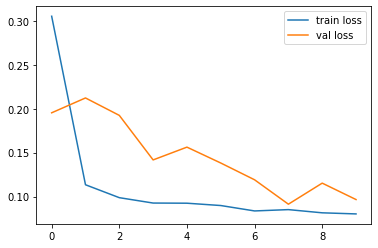

In [12]:
plt.plot(hist.history["loss"],label="train loss")
plt.plot(hist.history["val_loss"],label="val loss")
plt.legend()
plt.show()

In [17]:
### pridicting all of train set (CLOSE) ###
# this migh take a while (1-2 min)
real = []
future = []
for i in range(0,len(data),future_prediction):
    pred = model.predict(data[i].reshape((1,past_window,5)))
    future.append(pred)
    real.append(org_labels[i].reshape(future_prediction))

future = np.array(future).reshape( (len(future),future_prediction) )
future = (future * labels_std) + labels_mean
future = np.array(future).reshape( (np.shape(future)[0]*np.shape(future)[1]) )
real = np.array(real).reshape((len(real)*future_prediction))

     MAE: 73.69640649126919


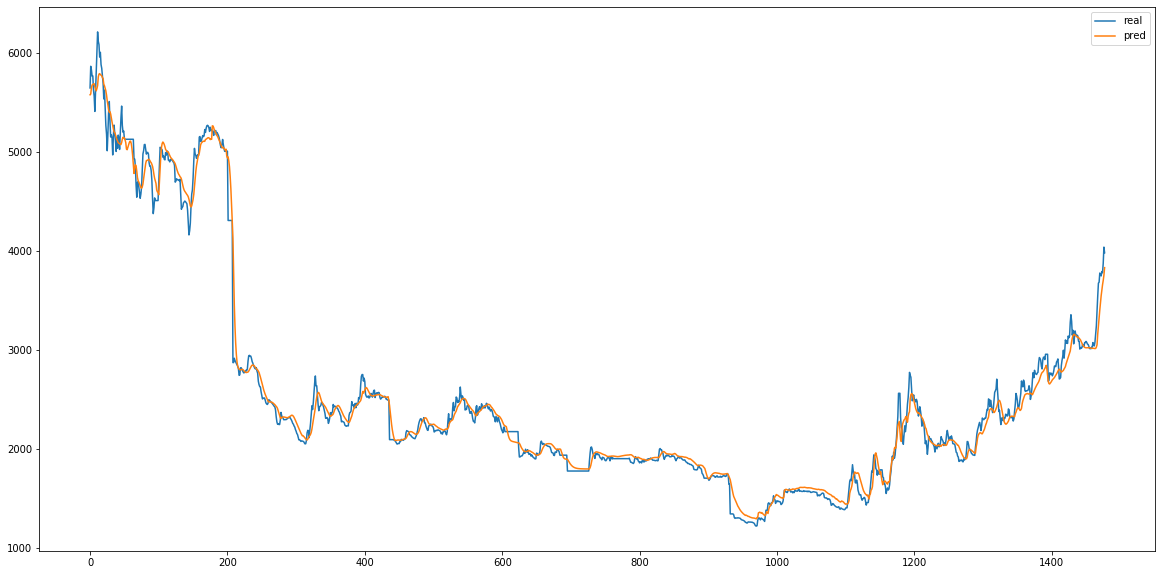

In [18]:
# ploting real and predicted prices
plt.figure(figsize=(20,10))
plt.plot(real,label="real")
plt.plot(future,label="pred")
plt.legend()
print(f"     MAE: {np.mean(abs(future - real))}")
plt.show()

      (smooth) MAE: 232.25083734211148


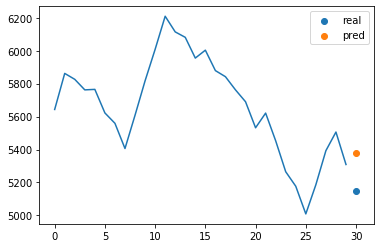

In [20]:
i = 30
pred = model.predict(data[i].reshape(1,past_window,5))
pred = (pred * labels_std) + labels_mean
plt.plot(range(past_window),org_data[i,:,1])
plt.scatter(range(past_window,past_window+future_prediction),org_labels[i].reshape((future_prediction)),label="real")
plt.scatter(range(past_window,past_window+future_prediction),pred.reshape((future_prediction)),label="pred")
plt.legend()
print(f"      (smooth) MAE: {np.mean(abs(pred.reshape((future_prediction))-org_labels[i].reshape((future_prediction))))}")

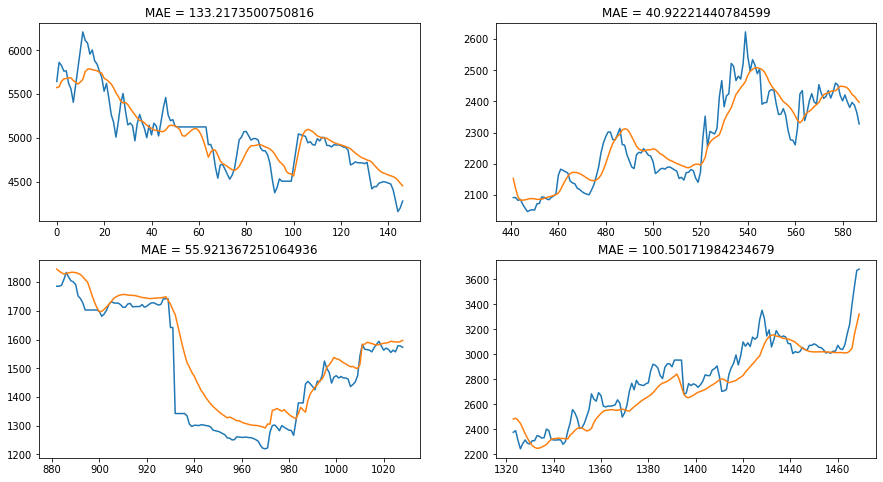

In [21]:
### ploting 4 of the train set data and their predictions
plt.figure(figsize=(15,8))
step = int(len(real)/10)

plt.subplot(2,2,1)
plt.plot(range(0,step),real[:step])
plt.plot(range(0,step),future[:step])
mae = np.mean(abs(future[:step]-real[:step]))
plt.title(f"MAE = {mae}" )

plt.subplot(2,2,2)
plt.plot(range(step*3,step*4),real[step*3:step*4])
plt.plot(range(step*3,step*4),future[step*3:step*4])
mae = np.mean(abs(future[step*3:step*4]-real[step*3:step*4]))
plt.title(f"MAE = {mae}" )

plt.subplot(2,2,3)
plt.plot(range(step*6,step*7),real[step*6:step*7])
plt.plot(range(step*6,step*7),future[step*6:step*7])
mae = np.mean(abs(future[step*6:step*7]-real[step*6:step*7]))
plt.title(f"MAE = {mae}" )

plt.subplot(2,2,4)
plt.plot(range(step*9,step*10),real[step*9:step*10])
plt.plot(range(step*9,step*10),future[step*9:step*10])
mae = np.mean(abs(future[step*9:step*10]-real[step*9:step*10]))
plt.title(f"MAE = {mae}" )

plt.show()